# Multilayer Perceptrons and Activation Functions (November 16th, 2024)

## Problem 1: Car performance prediction

### Download the dataset

In [ ]:
!gdown -cq 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

### Import important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from tqdm import tqdm

### Set up the seeds

In [ ]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

### Set up `torch.device`

In [ ]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Read the dataset

In [ ]:
dataset_path = 'Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


### Preprocess the dataset

In [ ]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Implement `DataLoader`

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

### Implement MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

In [ ]:
model

MLP(
  (linear1): Linear(in_features=9, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
from torchsummary import summary

summary(model, input_size=(X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             640
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 1]              65
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=f2b6a8315c85cf1c63421b1a46173d9852540c3820728686246fbc4aaba11117
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


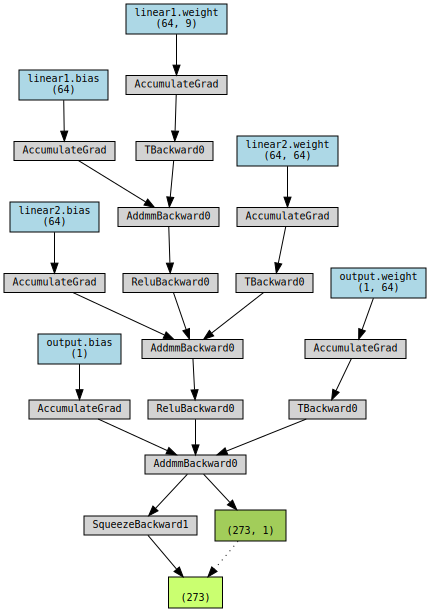

In [ ]:
from torchviz import make_dot
import torch

# Create a dummy input tensor with the same dimensions as your input
X_dummy = torch.rand_like(X_train).to(device)

# Pass the input through the model to get the output
output = model(X_dummy)

# Visualize the model
make_dot(output, params=dict(model.named_parameters()))

In [ ]:
!pip install torchview

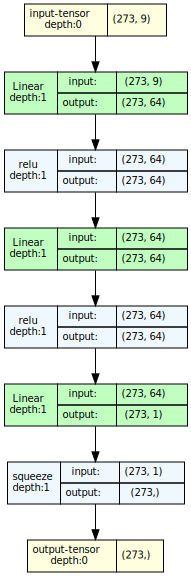

In [ ]:
from torchview import draw_graph

graph = draw_graph(model, input_size=X_train.shape)
# graph.visual_graph.node_attr["fontname"] = "Helvetica"
graph.visual_graph

### Define loss function and optimizer

In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Define function for R2 metric

In [ ]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2.cpu().detach()

### Train the model

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 415.680	Validation loss: 266.608

EPOCH 2:	Training loss: 279.443	Validation loss: 29.002

EPOCH 3:	Training loss: 43.685	Validation loss: 24.268

EPOCH 4:	Training loss: 34.817	Validation loss: 21.399

EPOCH 5:	Training loss: 13.927	Validation loss: 13.369

EPOCH 6:	Training loss: 8.384	Validation loss: 7.452

EPOCH 7:	Training loss: 12.746	Validation loss: 30.748

EPOCH 8:	Training loss: 16.547	Validation loss: 30.202

EPOCH 9:	Training loss: 17.015	Validation loss: 4.864

EPOCH 10:	Training loss: 7.088	Validation loss: 4.994

EPOCH 11:	Training loss: 6.485	Validation loss: 7.763

EPOCH 12:	Training loss: 11.172	Validation loss: 6.716

EPOCH 13:	Training loss: 14.841	Validation loss: 34.499

EPOCH 14:	Training loss: 23.490	Validation loss: 11.089

EPOCH 15:	Training loss: 9.413	Validation loss: 18.477

EPOCH 16:	Training loss: 13.825	Validation loss: 13.186

EPOCH 17:	Training loss: 12.076	Validation loss: 9.473

EPOCH 18:	Training loss: 9.756	Validation loss

### Evaluate the model

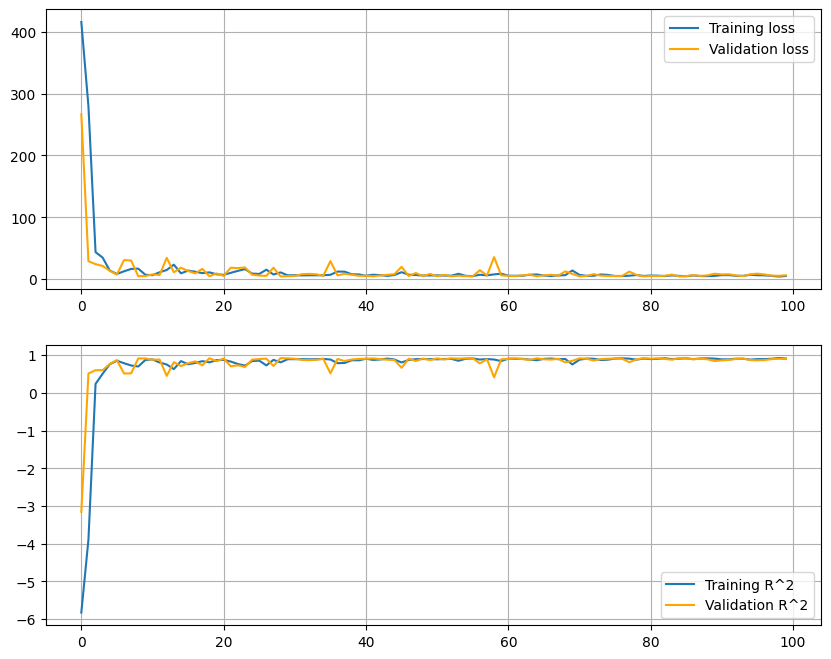

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss', color='orange')
ax1.grid()
ax1.legend()

ax2.plot(train_r2, label='Training R^2')
ax2.plot(val_r2, label='Validation R^2', c='orange')
ax2.grid()
ax2.legend()

# plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test.to(device))
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.851510226726532


## Problem 2: Classification for non-linear data

### Download the dataset

In [ ]:
!gdown -cq 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

### Import important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Set up the seeds and `torch.device`

In [ ]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

### Read the dataset

In [ ]:
data_path = 'NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [ ]:
print(X.shape, y.shape)

(300, 2) (300,)


### Split the dataset

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [ ]:
X_train.shape, y_train.shape

((210, 2), (210,))

### Normalize the dataset

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

### Build the DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

### Implement the MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

### Define loss function and optimizer

In [ ]:
lr = 1e-1
# Param:
# input: of shape (N, C)
# target: of shape (N) (index-based) or (N, C) (probability-based)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Implement metric

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

### Train the model

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.939	Validation loss: 0.864

EPOCH 2:	Training loss: 0.750	Validation loss: 0.815

EPOCH 3:	Training loss: 0.715	Validation loss: 0.799

EPOCH 4:	Training loss: 0.689	Validation loss: 0.791

EPOCH 5:	Training loss: 0.670	Validation loss: 0.780

EPOCH 6:	Training loss: 0.654	Validation loss: 0.747

EPOCH 7:	Training loss: 0.646	Validation loss: 0.724

EPOCH 8:	Training loss: 0.616	Validation loss: 0.704

EPOCH 9:	Training loss: 0.616	Validation loss: 0.694

EPOCH 10:	Training loss: 0.610	Validation loss: 0.666

EPOCH 11:	Training loss: 0.577	Validation loss: 0.666

EPOCH 12:	Training loss: 0.596	Validation loss: 0.642

EPOCH 13:	Training loss: 0.556	Validation loss: 0.625

EPOCH 14:	Training loss: 0.537	Validation loss: 0.608

EPOCH 15:	Training loss: 0.521	Validation loss: 0.604

EPOCH 16:	Training loss: 0.530	Validation loss: 0.587

EPOCH 17:	Training loss: 0.511	Validation loss: 0.566

EPOCH 18:	Training loss: 0.498	Validation loss: 0.569

EPOCH 19:	Training

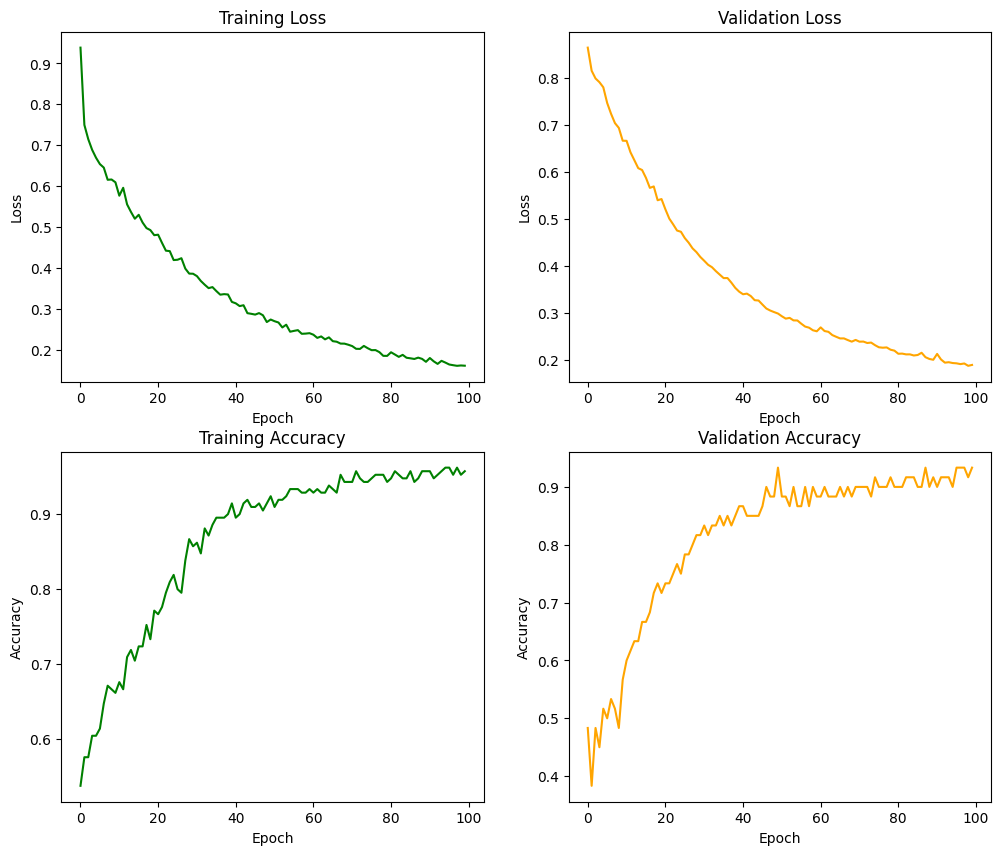

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluate the model

In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9333333333333333


## Problem 3: Sentiment analysis for images

### Download the dataset

In [ ]:
!gdown -cq 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

In [ ]:
!unzip -q "FER-2013.zip" -d "FER-2013"

### Import important libraries

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from os.path import join

### Set up the seeds and `torch.device`

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

### Read the datasets

In [ ]:
train_dir = 'FER-2013/train'
test_dir = 'FER-2013/test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

In [ ]:
label2idx

{'neutral': 0,
 'happy': 1,
 'disgust': 2,
 'surprise': 3,
 'fear': 4,
 'sad': 5,
 'angry': 6}

### Build the `DataLoader`

In [ ]:
test_img_path = join(train_dir, 'angry/Training_10118481.jpg')
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [ ]:
img.shape

(48, 48, 3)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(list(zip(self.img_paths, self.img_labels)),
                                                    train_size=train_ratio,
                                                    random_state=random_state,
                                                    stratify=self.img_labels)
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [ ]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True,
                             label2idx, split='train')
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True,
                           label2idx, split='val')
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True,
                            label2idx, split='test')
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

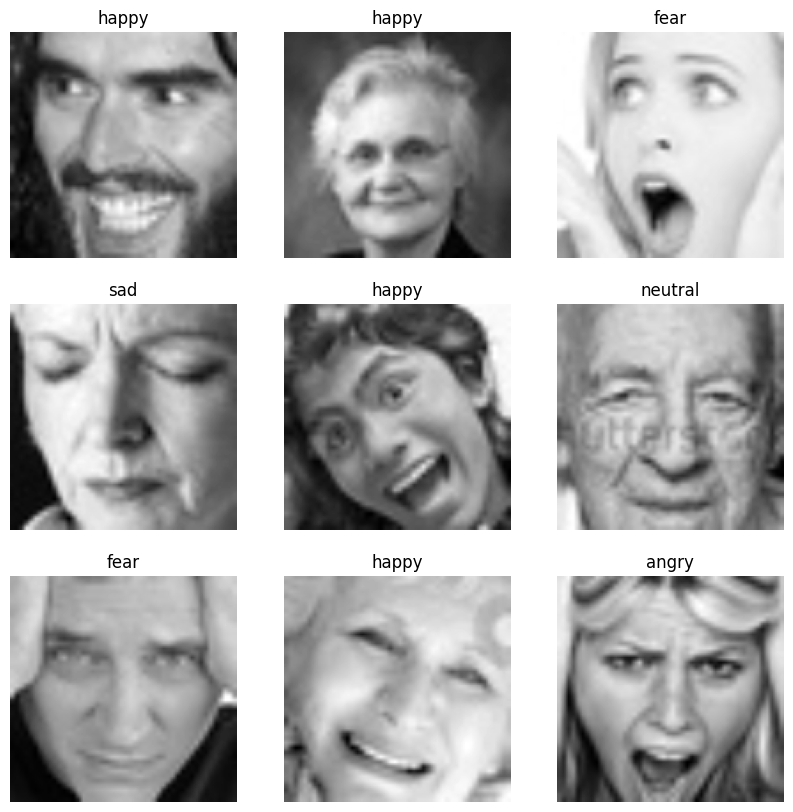

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()),
               vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

### Implement the MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)


input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

### Define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Define the metric function

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

### Train the model

In [ ]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.923	Validation loss: 1.890

EPOCH 2:	Training loss: 1.857	Validation loss: 1.833

EPOCH 3:	Training loss: 1.815	Validation loss: 1.806

EPOCH 4:	Training loss: 1.792	Validation loss: 1.789

EPOCH 5:	Training loss: 1.775	Validation loss: 1.776

EPOCH 6:	Training loss: 1.759	Validation loss: 1.761

EPOCH 7:	Training loss: 1.742	Validation loss: 1.744

EPOCH 8:	Training loss: 1.723	Validation loss: 1.725

EPOCH 9:	Training loss: 1.702	Validation loss: 1.704

EPOCH 10:	Training loss: 1.681	Validation loss: 1.684

EPOCH 11:	Training loss: 1.663	Validation loss: 1.669

EPOCH 12:	Training loss: 1.647	Validation loss: 1.656

EPOCH 13:	Training loss: 1.635	Validation loss: 1.647

EPOCH 14:	Training loss: 1.623	Validation loss: 1.641

EPOCH 15:	Training loss: 1.614	Validation loss: 1.631

EPOCH 16:	Training loss: 1.605	Validation loss: 1.626

EPOCH 17:	Training loss: 1.596	Validation loss: 1.620

EPOCH 18:	Training loss: 1.587	Validation loss: 1.615

EPOCH 19:	Training

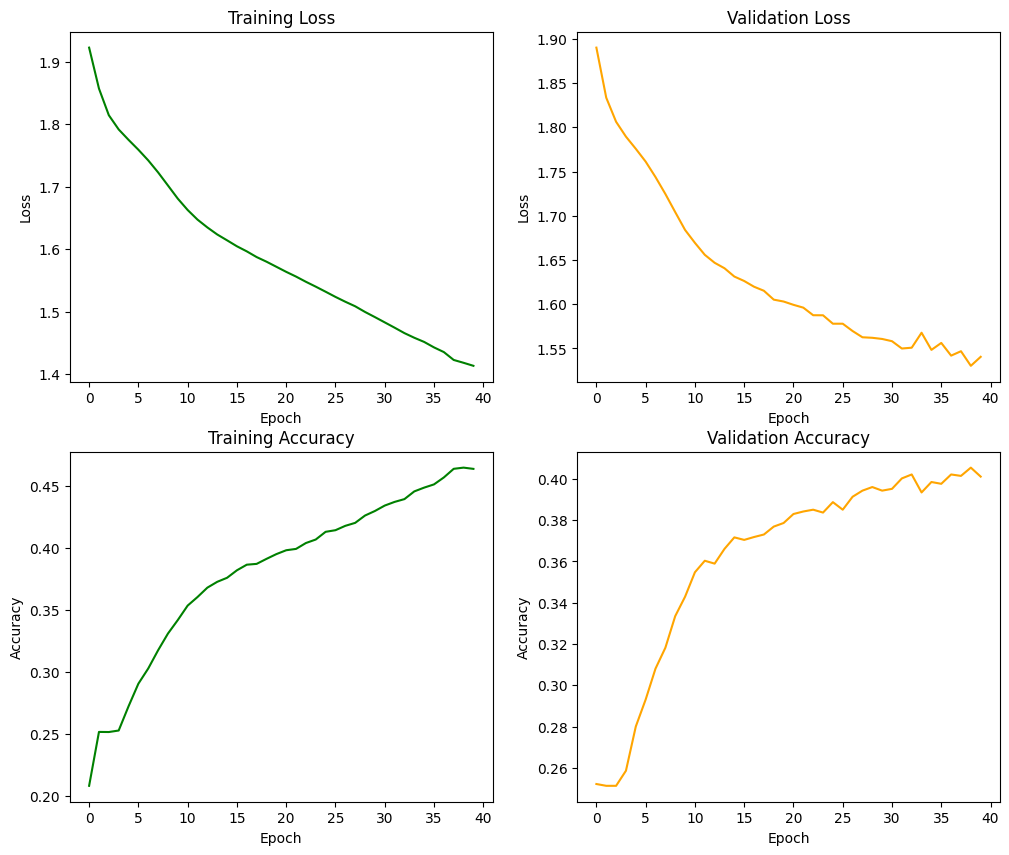

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluate the model

In [ ]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    outputs = model(X_samples)

  test_predict.append(outputs.cpu())
  test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  val_acc = compute_accuracy(test_predict, test_target)

  print('Evaluation on test set:')
  print(f'Accuracy: {val_acc}')

Evaluation on test set:
Accuracy: 0.2
